<center><img src="https://images.twinkl.co.uk/tw1n/image/private/t_630/image_repo/b8/06/t-lf-242-pupil-voice-learning-child-led-learning-peer-assessment-cards_ver_1.jpg" height="100"></center>

# Detección de incoherencias en evaluación por pares

Profesor: Juan Ramón Rico (<juanramonrico@ua.es>)

## Descripción
---
No cabe duda que las redes neuronales han avanzado en tareas donde se usa texto y valores numéricos. Concretametne en las encuestas o en la evaluación por pares es habitual encontrar valores numéricos (libres o sujetos a una escala - Likert) y comentarios de los evaluadores respecto a las secciones evaluadas en forma de texto (feedback).

- Artículo sobre evaluación por pares donde se han usado redes recurrentes entre otras metodologías para detectar incongruencias en las respuestas <https://www.sciencedirect.com/science/article/pii/S0360131519301629?dgcid=author> ha servido como base para esta actividad.
---


# Introducción

El uso de la evaluación por pares para actividades abiertas tiene ventajas tanto para los profesores como para los estudiantes. Los profesores pueden reducir la carga de trabajo del proceso de corrección y los estudiantes logran una mejor comprensión de la materia al evaluar las actividades de sus compañeros. Para facilitar el proceso, es aconsejable proporcionar a los estudiantes una rúbrica sobre la cual realizar la evaluación de sus compañeros; sin embargo, limitarse a proporcionar sólo puntuaciones numéricas es perjudicial, ya que impide proporcionar una retroalimentación valiosa a otros compañeros. Dado que esta evaluación produce dos modalidades de la misma evaluación, a saber, la puntuación numérica y la retroalimentación textual, es posible aplicar técnicas automáticas para detectar inconsistencias en la evaluación, minimizando así la carga de trabajo de los profesores para supervisar todo el proceso.

Esta actividad estará enfocada en solo una parte de la detección de incongruencias que será la predicción de calificación de una sección usando únicamente información textual.

# Conjunto de datos

Los datos que vamos a utilizar para esta se pueden descargar en un archivo tipo CSV donde figura:

- `activity`: es la actividad desarrollada, en este caso 1 o 2. Son actividades independientes y los más lógico es entrenar modelos (redes neuronales) independientes para cada una;
-  `year`:  año de comienzo del curso académico estudiado;
- `group`: con valores de 1 si es de mañana o 2 si es de tarde;
- `evaluator`: identificador interno del evaluador para una actividad concreta (la actividad 1 o la 2, de forma excluyente); 
- `work` : es el identificador del trabajo. La entrega se realizaba mediante una URL por lo que hay ocasiones en la que es privada o no accesible y no se ha podido evaluar.
- `secction`: número de sección que se evalua dentro de cada actividad, o 'grade1', 'grade2' cuando se trata de la nota final del trabajo evaluado.
- `value`: valor numérico comprendido entre 0 y 3. Siendo 0 no realizado o realizado incorrectamente y 3 realizado correctamente. Este número puede tener decimales debido a que corresponde al promedio de los valores de la sección. 
- `feedback`: texto libre correspondiente a las recomendaciones que el evaluador realiza en cada sección. Puede estar en blanco lo que indica que no se realizan comentarios y corresponde a que todo está correcto.

Para esta actividad necesitaremos `activity`, `value` y `feeback`.

In [ ]:
!pip install -q livelossplot

In [ ]:
import numpy as np
import pandas as pd
from livelossplot import PlotLossesKeras

data = pd.read_csv('https://www.dlsi.ua.es/~juanra/UA/dataset/dcadep/dcadep_melt_grades.csv.gz', sep='\t', decimal=',')
data.fillna('', inplace=True) # Reemplazar los valores en blanco por cadena vacías
data = data.sample(frac=1, random_state=123) # Barajar los ejemplos de entrada (filas de la tabla)
display(data.head())
data.dtypes

activity  year  group  evaluator  work section  value  \
23557         2  2015      2        103    59       7    2.0   
5292          1  2016      2        304   141       3    3.0   
22491         2  2016      2        333   137       6    3.0   
9655          1  2015      1         12    13  grade1    9.3   
25778         2  2016      1        204    88  grade2    9.4   

                                    feedback  
23557  Faltan datos para completar la página  
5292     Poco original y trabajo muy básico.  
22491                               Correcto  
9655                                          
25778

activity       int64
year           int64
group          int64
evaluator      int64
work           int64
section       object
value        float64
feedback      object
dtype: object

El atributo `section` contiene los identificadores de las diferentes secciones, así como las calificación final (`grade1` y `grade2` cuyos valores están entre 0 y 10) según la actividad. Esta actividad se tiene que evaluar por separado para la actividad 1 o 2 usando únicamente las secciones numéricas (1,2,3,4,5,6 y 7) cuyos valores oscilan entre 0 y 3.

In [ ]:
np.sort(data['section'].unique())

array(['1', '2', '3', '4', '5', '6', '7', 'grade1', 'grade2'],
      dtype=object)

# Visualizar las valoraciones

activity
1    [[AxesSubplot(0.125,0.125;0.336957x0.755), Axe...
2    [[AxesSubplot(0.125,0.125;0.336957x0.755), Axe...
dtype: object

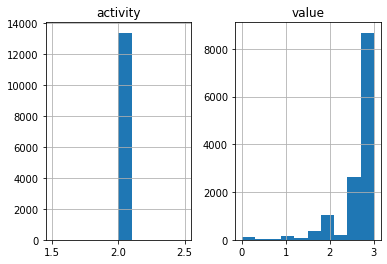

In [ ]:
data[data['section'].isin(['1','2','3','4','5','6','7'])][['activity','value']].groupby('activity').hist()

Podemos ver como la mayoría de valores son cercanos a 3. No obstante tenemos que predecir cuando este valor va disminuyendo atendiendo a las palabras usadas en el contexto restringido de cada actividad.

# Preprocesar el texto

Es necesario preprocesar el texto para descartar símbolos de puntuación, valorar igualmente a palabras en mayúscula y minúscula y extraeer la raiz de las palabras (lemas) para procesarlas como iguales.

Para ello usaremos bibliotecas de procesamiento de lenguaje natural (PLN).

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))
  
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
print(stopwords.words('spanish'))

tokenizer = RegexpTokenizer(r'\w+')
stemmer = SnowballStemmer("spanish",ignore_stopwords=True)

preprocessed_feedback = []
for i in data.feedback:
  tokens = [stemmer.stem(word) for word in tokenizer.tokenize(i.lower())]
  tokens = [word for word in tokens if word not in stop_words]
  preprocessed_feedback.append(np.array(' '.join(tokens)))

data['feedback prep'] = preprocessed_feedback
data['feedback prep'] = data['feedback prep'].astype('str')
data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

activity  year  group  evaluator  work section  value  \
23557         2  2015      2        103    59       7    2.0   
5292          1  2016      2        304   141       3    3.0   
22491         2  2016      2        333   137       6    3.0   
9655          1  2015      1         12    13  grade1    9.3   
25778         2  2016      1        204    88  grade2    9.4   

                                    feedback           feedback prep  
23557  Faltan datos para completar la página  falt dat complet pagin  
5292     Poco original y trabajo muy básico.   original trabaj basic  
22491                               Correcto                 correct  
9655                                                                  
25778

In [ ]:
data.dtypes

activity           int64
year               int64
group              int64
evaluator          int64
work               int64
section           object
value            float64
feedback          object
feedback prep     object
dtype: object

# Convertir datos de entrenamiento a la forma correcta

En este caso los datos de tipo texto hay transformarlos en secuencias de número que recibirá la red neuronal. 

- En el siguiente enlace <https://www.programcreek.com/python/example/106871/keras.preprocessing.text.Tokenizer> hay varios ejemplos de como convertir el texto que ya tenemos preprocesado a secuencias de números;
- De la secuencia de números hay que aplicar `pad_sequences` como truco para igualar la longitud de todas las secuencias de entreada. Nos facilita la tarea de entrenar un red recurrente con `Keras`.


In [ ]:
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras_preprocessing.sequence import pad_sequences
# Seleccionar la actividad 1 y sus secciones, ya que se evaluan por separado. La actividad 2 se seleccionaría por separado
new_data = data[(data['activity']==1) & data['section'].isin(['1','2','3','4','5','6','7'])]

tokenizer = Tokenizer()
textos = new_data['feedback prep']
tokenizer.fit_on_texts(textos)
#print(tokenizer.word_counts)
sequences = []
for seq in tokenizer.texts_to_sequences_generator(textos):
    sequences.append(seq)

tokenizer.fit_on_sequences(sequences)
# Modes:
# 1) binary : The default value that tells us about the presence of each word in a document.
# 2) count : As the name suggests, the count for each word in the document is known.
# 3) tfidf : The TF-IDF score for each word in the document.
# TF-IDF or Term Frequency – Inverse Document Frequency, works by checking the relevance of a word in a given text corpus.
# In this mode, a proportional score is given to words on the basis of the number of times they occur in the text corpus. 
# In this way, this model can determine which words are worthy and which aren’t.
# 4) freq : The frequency tells us about ratio of words in each document.
matrix = tokenizer.texts_to_matrix(textos, "tfidf")
#X = matrix # Valores de new_data['feedback prep'] con el padding aplicado
X = matrix # Valores de new_data['feedback prep'] con el padding aplicado
y = new_data['value'].values

totalPalabras = sum([x for _,x in tokenizer.word_counts.items()])
vocabSize = len(tokenizer.word_counts.items())+1
print(matrix.shape) 
# for i in range(len(X[0])):
#   print(X[0][i])
print(vocabSize)
#print(tokenizer.word_counts.items())
print(totalPalabras)
print(X.shape)
print(y.shape)

(9500, 1539)
1539
31092
(9500, 1539)
(9500,)


# Creando la red neuronal

Se han preprocesado los datos y los hemos convertido al formato correcto. Ahora tenemos que diseñar nuestra red para entrenarla y realizar las predicciones.

En el caso de codificar la entrada como un conjunto de palabras (Bag of Words) tendremos un vector de entrada con todas las palabras posibles del vocabulario. Cada posición del vector representa si está presente la palabra o no, el número de veces que se repite, o el valor TF-IDF correspondiente. La dimensión incial de la red cuando entrena será de `(batch_size, vocabulary_len)`.

Otro caso diferente corresponde a una codificación del la entrada atendiendo a una secuencia. Cada valor (entero) del vector de entrada representa a una palabra y la entrada cumple con estas tres dimensiones `(batch_size, time_steps, seq_len)` que necesita una red recurrente.

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential  
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Dense, Embedding



activation = "relu"
batch_size = 32
optimizer = 'adam'
input_shape = (batch_size,vocabSize)
epochs = 100

def rnn_model():

  model = keras.Sequential([
      keras.layers.Dense(256,input_dim=vocabSize, activation=activation),
      keras.layers.Dropout(0.9),
      keras.layers.Dense(128, activation=activation),
      keras.layers.Dense(64, activation=activation),
      keras.layers.Dense(32, activation=activation),
      keras.layers.Dense(16, activation=activation),
      keras.layers.Dense(8, activation=activation),
      keras.layers.Dense(1)
  ])
  model.compile(optimizer = optimizer, loss = 'mae') 
  
  return model

# hay que rellenar la tipología de la red orientada a predecir un valor entre 0 y 3 (modelos de regresión)



# Entrenamiento del modelo

Vamos a dividir el conjunto en entrenamiento y test para comprobar nuestro modelo. Para ello tenemos que elegir un tipo de actividad (1 o 2), sus valores y feedback (preprocesado).

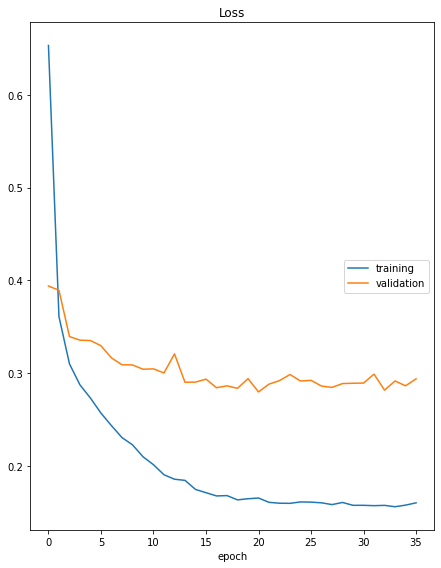

Loss
	training         	 (min:    0.156, max:    0.653, cur:    0.160)
	validation       	 (min:    0.280, max:    0.394, cur:    0.294)
241/241 [==============================] - 2s 7ms/step - loss: 0.1600 - val_loss: 0.2937
fold:  10
30/30 [==============================] - 0s 2ms/step
329 552 1650 6019
mae:  0.34
rsme:  0.4979
[[ 22   3   4   8]
 [  0  15  18  29]
 [  2  20  69  92]
 [  2  10  70 586]]
              precision    recall  f1-score   support

         0.0       0.85      0.59      0.70        37
         1.0       0.31      0.24      0.27        62
         2.0       0.43      0.38      0.40       183
         3.0       0.82      0.88      0.85       668

    accuracy                           0.73       950
   macro avg       0.60      0.52      0.55       950
weighted avg       0.71      0.73      0.72       950

0.728421052631579
maes:  [0.2695, 0.2758, 0.2821, 0.3189, 0.3105, 0.3032, 0.2747, 0.2916, 0.2695, 0.34]
rsmes:  [0.3937, 0.3789, 0.4042, 0.4621, 0.4621, 0.4

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.utils.multiclass import type_of_target

current_activity = 2 # 1 or 2

new_data = data[data.activity==current_activity]

skf = StratifiedKFold(n_splits = 10, random_state = 890, shuffle= True)
# print(type_of_target(y))
# print(type_of_target(X))

maes=[]
rsmes=[]
y = np.rint(y)
fold=0
### MAIN PROGRAM ---------------------------------------------------------------------------------------------------------------------------------- 
for train_index, test_index in skf.split(X,y):
  fold+=1
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  y_test=np.rint(y_test)
  y_train=np.rint(y_train)

  #n = int(len(new_data)*0.9)
  model = rnn_model()

  # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=890)


  n = int(len(X)*0.9)

  # X_train, X_test = X[:n], X[n:]
  # y_train, y_test = y[:n], y[n:]
  print(y_train[1])
  print(X_train[1])

  print(len(X_train))

  print(X_train.shape)
  # Para verificar que el modelo entrena correctamente crearemos un conjunto de validación del 10% de los datos con el parámetro ()
  patience = 15
  callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
  model.fit(X_train, y_train, epochs = epochs, validation_split=0.1, batch_size = batch_size,callbacks=[callback,PlotLossesKeras()])
  print('fold: ',fold)
  #y_pred = model.predict(X_test)
  y_pred = np.clip(model.predict(X_test), 0, 3)


  # cero, uno, dos, tres = 0,0,0,0
  y2 = []
  x2 = []
  # for i in range(len(y_train)):
  # #   print(y_test[i])
  #     if y_train[i] == 0:
  #       cero = cero + 1
  #     if y_train[i] == 1:
  #       uno = uno + 1
  #     if y_train[i] == 2:
  #       dos = dos + 1
  #     if y_train[i] == 3:
  #       tres = tres + 1

  # print(cero, uno, dos, tres)


  from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_absolute_error, mean_squared_error

  #df = pd.DataFrame(data, columns= np.array(data.columns))
  #model.evaluate(X_test, y_test)
  y_pred=np.rint(y_pred)

  mae = round(mean_absolute_error(y_test,y_pred),4)
  rsme = round(mean_squared_error(y_test,y_pred),4)
  print('mae: ',mae)
  print('rsme: ',rsme)
  rsmes.append(rsme)
  maes.append(mae)

  print(confusion_matrix(y_test,y_pred))
  print(classification_report(y_test,y_pred))
  print(accuracy_score(y_test, y_pred))

# Resultados finales:

print('maes: ',maes)
print('rsmes: ',rsmes)

In [ ]:
print('maes: ',maes)
print('rsmes: ',rsmes)

maes:  [0.4211]
rsmes:  [0.72]
